In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import skimage
from skimage import io

In [5]:
from sklearn.feature_extraction import image

from https://github.com/BVLC/caffe/blob/master/examples/01-learning-lenet.ipynb

In [13]:
import os

In [14]:
os.listdir('data')

[u'Bolivia.png',
 u'Germany.png',
 u'lenet.prototxt',
 u'snapshots',
 u'lenet_solver.prototxt',
 u'Brazil.png',
 u'.ipynb_checkpoints',
 u'MN.png',
 u'KS.png',
 u'Thailand.png']

In [26]:
features = []
str_labels = []
for filename in os.listdir('data'):
    if filename.endswith('.png'):
        img = io.imread('data/%s'%filename)
        img = skimage.color.rgb2grey(img)
        patches = image.extract_patches_2d(img, (28, 28), 1000)
        features += patches.tolist()
        str_labels += [filename.split('.')[0]]*len(patches)
features = np.array(features)
str_labels = np.array(str_labels)

In [27]:
features.shape,str_labels.shape

((6000, 28, 28), (6000,))

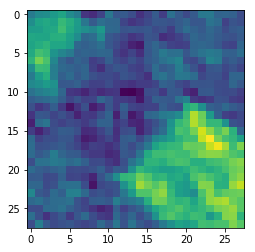

In [28]:
plt.imshow(features[0])

https://github.com/caffe2/tutorials/blob/master/create_your_own_dataset.ipynb

In [10]:
# First let's import some necessities
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import urllib2 # for downloading the dataset from the web.
import numpy as np
from matplotlib import pyplot
from StringIO import StringIO
from caffe2.python import core, utils, workspace
from caffe2.proto import caffe2_pb2

In [29]:
set(str_labels)

{u'Bolivia', u'Brazil', u'Germany', u'KS', u'MN', u'Thailand'}

In [43]:
loc2id = dict(zip(sorted(set(str_labels)),range(len(set(str_labels)))))

In [46]:
labels = np.array([loc2id[_] for _ in str_labels])

In [47]:
np.random.seed(123)

random_index = np.random.permutation(len(str_labels))
features = features[random_index]
labels = labels[random_index]

train_features = features[:100]
train_labels = labels[:100]
test_features = features[100:]
test_labels = labels[100:]

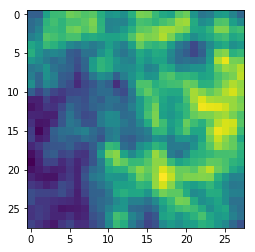

In [48]:
plt.imshow(train_features.mean(0))

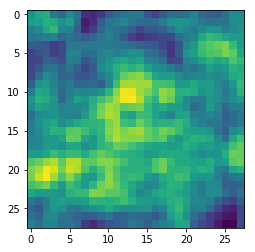

In [49]:
plt.imshow(test_features.mean(0))

In [50]:
# First, let's see how one can construct a TensorProtos protocol buffer from numpy arrays.
feature_and_label = caffe2_pb2.TensorProtos()
feature_and_label.protos.extend([
    utils.NumpyArrayToCaffe2Tensor(features[0]),
    utils.NumpyArrayToCaffe2Tensor(labels[0])])
print('This is what the tensor proto looks like for a feature and its label:')
print(str(feature_and_label))
print('This is the compact string that gets written into the db:')
print(feature_and_label.SerializeToString())

This is what the tensor proto looks like for a feature and its label:
protos {
  dims: 28
  dims: 28
  data_type: DOUBLE
  double_data: 0.70489372549
  double_data: 0.726772156863
  double_data: 0.673590196078
  double_data: 0.508364313725
  double_data: 0.471969019608
  double_data: 0.570260392157
  double_data: 0.651703921569
  double_data: 0.732008627451
  double_data: 0.805670196078
  double_data: 0.74444627451
  double_data: 0.59354627451
  double_data: 0.555722352941
  double_data: 0.624636862745
  double_data: 0.64311372549
  double_data: 0.635821176471
  double_data: 0.651476862745
  double_data: 0.627343529412
  double_data: 0.647478431373
  double_data: 0.681900784314
  double_data: 0.705154509804
  double_data: 0.70749254902
  double_data: 0.690751372549
  double_data: 0.653210980392
  double_data: 0.599984313725
  double_data: 0.566119607843
  double_data: 0.538430588235
  double_data: 0.491668627451
  double_data: 0.555483529412
  double_data: 0.549223137255
  double_data:

In [51]:
# Now, actually write the db.

def write_db(db_type, db_name, features, labels):
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(features.shape[0]):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([
            utils.NumpyArrayToCaffe2Tensor(features[i]),
            utils.NumpyArrayToCaffe2Tensor(labels[i])])
        transaction.put(
            'train_%03d'.format(i),
            feature_and_label.SerializeToString())
    # Close the transaction, and then close the db.
    del transaction
    del db

write_db("minidb", "geo_train.minidb", train_features, train_labels)
write_db("minidb", "geo_test.minidb", test_features, test_labels)

In [52]:
net_proto = core.Net("geo_reader")
dbreader = net_proto.CreateDB([], "dbreader", db="geo_train.minidb", db_type="minidb")
net_proto.TensorProtosDBInput([dbreader], ["X", "Y"], batch_size=16)

print("The net looks like this:")
print(str(net_proto.Proto()))

The net looks like this:
name: "geo_reader"
op {
  output: "dbreader"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "minidb"
  }
  arg {
    name: "db"
    s: "geo_train.minidb"
  }
}
op {
  input: "dbreader"
  output: "X"
  output: "Y"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 16
  }
}



In [53]:
workspace.CreateNet(net_proto)

True

In [54]:
# Let's run it to get batches of features.
workspace.RunNet(net_proto.Proto().name)
print("The first batch of feature is:")
print(workspace.FetchBlob("X"))
print("The first batch of label is:")
print(workspace.FetchBlob("Y"))

# Let's run again.
workspace.RunNet(net_proto.Proto().name)
print("The second batch of feature is:")
print(workspace.FetchBlob("X"))
print("The second batch of label is:")
print(workspace.FetchBlob("Y"))

The first batch of feature is:
[[[0.70489373 0.72677216 0.6735902  ... 0.53843059 0.49166863 0.55548353]
  [0.54922314 0.56941216 0.5932549  ... 0.54296314 0.44914235 0.49896039]
  [0.4587898  0.44508353 0.50842471 ... 0.55897765 0.45253608 0.43317255]
  ...
  [0.19645373 0.1885949  0.20873059 ... 0.40154039 0.39005843 0.38111412]
  [0.26702    0.22750588 0.23869725 ... 0.22068863 0.22042078 0.24453843]
  [0.46417765 0.33169255 0.25075333 ... 0.20399216 0.20260824 0.26257059]]

 [[0.45072314 0.43023647 0.58034941 ... 0.66580824 0.57594745 0.52305529]
  [0.42188039 0.37814706 0.59520941 ... 0.60423176 0.5185902  0.48587137]
  [0.41010784 0.3932749  0.62238471 ... 0.59194627 0.49232275 0.45708118]
  ...
  [0.70383765 0.7474949  0.70123882 ... 0.71598431 0.72096157 0.75827333]
  [0.64811725 0.69541333 0.68416863 ... 0.70784353 0.69800549 0.71682549]
  [0.66580549 0.72066196 0.70632902 ... 0.70334157 0.68935961 0.6919349 ]]

 [[0.2795902  0.27257255 0.22799098 ... 0.25577098 0.26192471 0.2

https://github.com/caffe2/tutorials/blob/master/MNIST.ipynb

In [57]:
import os
import operator
import caffe2.python.predictor.predictor_exporter as pe

from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

net_drawer will not run correctly. Please install the correct dependencies.


No handlers could be found for logger "caffe2.python.net_drawer"


In [ ]:

def AddModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    # Here, the data is flattened from a tensor of dimension 50x4x4 to a vector of length 50*4*4
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    relu3 = brew.relu(model, fc3, 'relu3')
    # Last FC Layer
    pred = brew.fc(model, relu3, 'pred', dim_in=500, dim_out=10)
    # Softmax Layer
    softmax = brew.softmax(model, pred, 'softmax')
    
    return softmax

In [58]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

In [59]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    # Compute cross entropy between softmax scores and labels
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # Compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # Track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # Use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # Specify the optimization algorithm
    optimizer.build_sgd(
        model,
        base_learning_rate=0.1,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )